# Ionization and Thermal History

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

## Notebook Initialization

In [8]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np

import darkhistory.physics as phys
import darkhistory.history.tla as tla

## Three-Level Atom

The three-level atom (TLA) model is a set of coupled differential equations governing the ionization and thermal history of the universe. In it's original form as proposed by Peebles [1] and Zel'dovich et al. [2], it assumes that the universe is entirely composed of hydrogen atoms with three levels: $n = 1$, $n = 2$ and the continuum, and that the only additional source of photons is the CMB blackbody radiation. A more recent explanation of this model is given in [4].

The TLA has been successfully modified to include dark matter energy injection [3]. This is done by introducing the ratio $f_c(z)$ of the energy injection rate due to DM annihilation/decay to the energy deposition rate into the IGM from these injections, in a given channel $c$ (ionization of hydrogen, excitation of hydrogen, or collisional heating of the IGM):

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{dep.}, c} = f_c(z) \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}, c} $$

Calculating $f_c(z)$ for use in these equations is one of the key goals of DarkHistory.

The TLA with DM is included in DarkHistory, and given $f_c(z)$, which is computed in other parts of the code, the TLA can be solved to give the ionization and thermal history of the universe with DM energy injection. Compared to the original TLA, our only important modification to the model is to solve in the differential equations in terms of $y \equiv \text{arctanh}[2(x_e - 0.5)]$, which makes the differential equations less stiff, and also guarantees that the ionization fraction $x_e$ is bounded between 0 and 1. 

The function that solves the TLA is `tla.get_history`. It takes a pair of initial conditions (IGM temperature, $x_e$), 3 functions detailing the ratio $f_c(z)$ for hydrogen ionization, hydrogen Lyman-$\alpha$ excitation and heating at a given $x_e$ and $1+z$, a function returning the DM injection rate, and finally a ratio of the redshift $1+z$ abscissa at which the solution is to be obtained. 

We will first solve the equation with no dark matter injection whatsoever.

---

[1] P. J. E. Peebles, Astrophys. J. **153**, 1 (1968).

[2] Y. B. Zel’dovich, V. G. Kurt, and R. A. Syunyaev, Sov. Phys. JETP **28** (1969).

[3] S. Galli, T. R. Slatyer, M. Valdes, and F. Iocco, Phys.
Rev. **D88**, 063502 (2013), 1306.0563.

[4]  Y. Ali-Haimoud and C. M. Hirata, Phys. Rev. **D83**, 043513 (2011), 1011.3758.

In [9]:
# Set all of the fractions and DM injection functions to return 0. 
def f_H_ion(rs, xe):
    return np.zeros_like(rs)

def f_H_exc(rs, xe):
    return np.zeros_like(rs)

def f_heating(rs, xe):
    return np.zeros_like(rs)

def dm_injection_rate(rs):
    return np.zeros_like(rs)

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(3000))

# Set the initial conditions. The initial temperature is the CMB temperature, 
# and the initial free electron fraction is 1. Strictly speaking, the code
# changes 1 to 1 - 1e-12, as otherwise y is infinite.
init_cond = [phys.TCMB(3000), 1]

# Obtain the solution
soln = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec)

[1, 3000.0, 0.0001, 2]

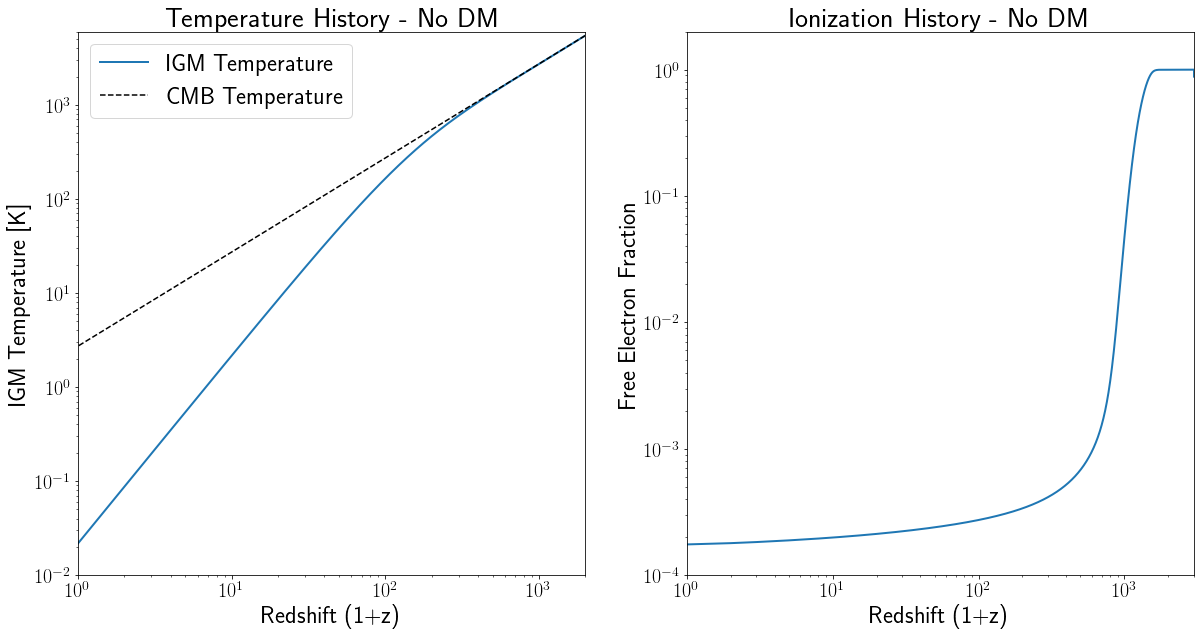

In [10]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM, = plt.plot(rs_vec, soln[:,0]/phys.kB, linewidth=2, label='IGM Temperature')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM, T_CMB], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Temperature History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e3])

ax = plt.subplot(1,2,2)
plt.rc('text', usetex=True)

plt.plot(rs_vec, soln[:,1], linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title('Ionization History - No DM', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])

## Three-Level Atom with Dark Matter

Now, we will introduce dark matter into the TLA equations. We introduce a dark matter species that decays with some (long) lifetime, decaying into electrons. The energy injection rate is:

$$ \left( \frac{dE}{dV \, dt} \right)_{\text{inj.}} = \frac{\rho_{\text{DM},0}}{\tau} (1 + z)^3  $$

where $\tau$ is the lifetime, and $\rho_{\text{DM},0}$ is the dark matter density today. 

The proper calculation of energy deposition of dark matter annihilation and decay is the key point of DarkHistory, but just to demonstrate how the TLA solution works, we will adopt two oversimplifications: 

1. The energy injected is promptly deposited. 

2. The energy is deposited into hydrogen ionization, excitation and heating according to the prescription proposed by Chen and Kamionkowski for electrons [1]. At zero ionization, the energy is deposited equally into each of these channels, but at full ionization, the energy is deposited only into heating, and not into ionization and excitation. 

This means that $f_{\text{H ion.}}(x_e) = (1-x_e)/3$, $f_{\text{H exc.}}(x_e) = (1-x_e)/3$, and $f_{\text{heat}}(x_e) = (1 + 2x_e)/3$. 

[1] Chen, Xue-Lei et al., "Particle decays during the cosmic dark ages", Phys.Rev. D70 (2004) 043502, astro-ph/0310473

In [11]:
# Set all of the fractions and DM injection functions to return 0. 
def f_H_ion(rs, xe):
    return (1-xe)/3

def f_H_exc(rs, xe):
    return (1-xe)/3

def f_heating(rs, xe):
    return (1+2*xe)/3

def dm_injection_rate(rs):
    # Set the desired lifetime here in seconds. 
    tau = 1e27
    return phys.rho_DM*rs**3/tau

# Initialize the redshift at which we want the solution. 
rs_vec = np.flipud(1 + np.arange(3000))

# Set the initial conditions. Setting the initial condition to be 1 will result in an error. 
init_cond = [phys.TCMB(3000), 0.99999]

# Obtain the solution
soln_DM = tla.get_history(init_cond, f_H_ion, f_H_exc, f_heating, dm_injection_rate, rs_vec)

[1, 3000.0, 0.0001, 2]

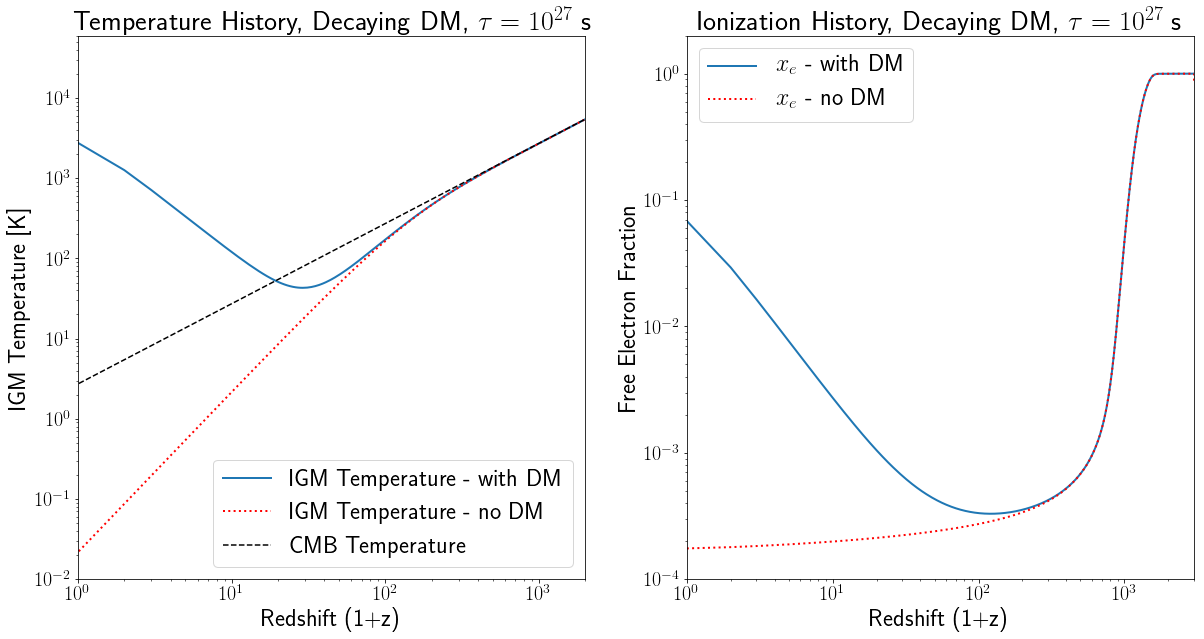

In [12]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)
plt.rc('text', usetex=True)

T_IGM_DM, = plt.plot(rs_vec, soln_DM[:,0]/phys.kB, linewidth=2, label='IGM Temperature - with DM')
T_IGM_noDM, = plt.plot(rs_vec, soln[:,0]/phys.kB, 'r:', linewidth=2, label='IGM Temperature - no DM')
T_CMB, = plt.plot(rs_vec, phys.TCMB(rs_vec)/phys.kB, 'k--', label='CMB Temperature')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[T_IGM_DM, T_IGM_noDM, T_CMB], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title(r'Temperature History, Decaying DM, $\tau = 10^{27}$ s', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('IGM Temperature [K]',fontsize=24)
plt.axis([1, 2e3, 1e-2, 6e4])

ax = plt.subplot(1,2,2)
plt.rc('text', usetex=True)

xe_DM, = plt.plot(rs_vec, soln_DM[:,1], linewidth=2, label=r'$x_e$ - with DM')
xe_noDM, = plt.plot(rs_vec, soln[:,1], 'r:', linewidth=2, label=r'$x_e$ - no DM')

ax.set_xscale('log')
ax.set_yscale('log')

plt.legend(handles=[xe_DM, xe_noDM], 
           fontsize=24)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.title(r'Ionization History, Decaying DM, $\tau = 10^{27}$ s', fontsize=28)
plt.xlabel('Redshift (1+z)',fontsize=24)
plt.ylabel('Free Electron Fraction',fontsize=24)
plt.axis([1, 3e3, 1e-4, 2])

From the ionization history, we can compute the optical depth, given by

$$ \Delta \tau = \int_{z_i}^{z_f} n_e(z) \sigma_T c \frac{dt}{dz} dz $$

between an initial redshift $z_i$ and a final redshift $z_f$. In this code, we can do this using `physics.get_optical_depth`. Here, we find the additional optical depth over the 3-level atom ionization history, which is directly constrained by the optical depth to recombination measured by Planck (see 1604.02457). 

In [7]:
# rs_vec is ordered from largest to smallest right now, because
# we had to flip the vector to solve the TLA differential equations.
delta_tau = (phys.get_optical_depth(np.flipud(rs_vec), soln_DM[:,1])
             -phys.get_optical_depth(np.flipud(rs_vec), soln[:,1])
             )

print('Increase in optical depth relative to no DM: ', delta_tau)

Increase in optical depth relative to no DM:  0.0236085252811
